### USING MINMAXSCALER TO NORMALIZE

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [6]:
train_seq = pd.read_csv('../datasets/train/train_text_seq.csv')
valid_seq = pd.read_csv('../datasets/valid/valid_text_seq.csv')
test_seq = pd.read_csv('../datasets/test/test_text_seq.csv')

In [5]:
df_train=pd.DataFrame(train_seq)
df_valid=pd.DataFrame(valid_seq)

In [7]:
df_train['input_str'] = df_train['input_str'].astype(float)
df_valid['input_str'] = df_valid['input_str'].astype(float)


In [8]:
scaler = MinMaxScaler()

X_train = df_train[['input_str']].values 
X_valid = df_valid[['input_str']].values 
X_train = scaler.fit_transform(X_train) 
X_valid = scaler.transform(X_valid)     


X_train = np.array(X_train, dtype=np.float32)
X_valid = np.array(X_valid, dtype=np.float32)

y_train = df_train['label'].values
y_valid = df_valid['label'].values

In [9]:
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(X_train))  # Input, Target are the same for autoencoders
valid_dataset = TensorDataset(torch.tensor(X_valid), torch.tensor(X_valid))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()  # Sigmoid activation for binary cross-entropy loss
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [11]:
autoencoder = Autoencoder()
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.AdamW(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)

In [12]:
num_epochs = 50
best_loss = float('inf')

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0
    for inputs, _ in train_loader:
        inputs = inputs.view(-1, 1)  # Reshape inputs for the model
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    autoencoder.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, _ in valid_loader:
            inputs = inputs.view(-1, 1)
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            valid_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {valid_loss/len(valid_loader):.4f}')

Epoch [1/50], Train Loss: 0.4961, Val Loss: 0.4077
Epoch [2/50], Train Loss: 0.3857, Val Loss: 0.3830
Epoch [3/50], Train Loss: 0.3757, Val Loss: 0.3784
Epoch [4/50], Train Loss: 0.3720, Val Loss: 0.3755
Epoch [5/50], Train Loss: 0.3708, Val Loss: 0.3751
Epoch [6/50], Train Loss: 0.3707, Val Loss: 0.3751
Epoch [7/50], Train Loss: 0.3705, Val Loss: 0.3750
Epoch [8/50], Train Loss: 0.3705, Val Loss: 0.3751
Epoch [9/50], Train Loss: 0.3705, Val Loss: 0.3750
Epoch [10/50], Train Loss: 0.3704, Val Loss: 0.3751
Epoch [11/50], Train Loss: 0.3706, Val Loss: 0.3751
Epoch [12/50], Train Loss: 0.3707, Val Loss: 0.3753
Epoch [13/50], Train Loss: 0.3703, Val Loss: 0.3750
Epoch [14/50], Train Loss: 0.3705, Val Loss: 0.3750
Epoch [15/50], Train Loss: 0.3704, Val Loss: 0.3750
Epoch [16/50], Train Loss: 0.3705, Val Loss: 0.3750
Epoch [17/50], Train Loss: 0.3704, Val Loss: 0.3750
Epoch [18/50], Train Loss: 0.3705, Val Loss: 0.3750
Epoch [19/50], Train Loss: 0.3706, Val Loss: 0.3750
Epoch [20/50], Train 

#### Accuracy

In [13]:
encoder = autoencoder.encoder


autoencoder.eval()
with torch.no_grad():
    encoded_train = encoder(torch.tensor(X_train).view(-1, 1)).numpy()
    encoded_valid = encoder(torch.tensor(X_valid).view(-1, 1)).numpy()


clf = LogisticRegression()
clf.fit(encoded_train, y_train)  
y_pred = clf.predict(encoded_valid)  


accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on compressed features:", accuracy)

Accuracy on compressed features: 0.49693251533742333


### USING STANDARDIZATION

In [14]:
mean_train = np.mean(X_train)
std_train = np.std(X_train)
mean_train = np.mean(X_train)
std_train = np.std(X_train)


In [15]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_train, dtype=torch.float32))
valid_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.float32), torch.tensor(X_valid, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [16]:
for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0
    for inputs, _ in train_loader:
        inputs = inputs.view(-1, 1)  
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    autoencoder.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, _ in valid_loader:
            inputs = inputs.view(-1, 1)
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            valid_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {valid_loss/len(valid_loader):.4f}')

Epoch [1/50], Train Loss: 0.3703, Val Loss: 0.3749
Epoch [2/50], Train Loss: 0.3703, Val Loss: 0.3749
Epoch [3/50], Train Loss: 0.3705, Val Loss: 0.3749
Epoch [4/50], Train Loss: 0.3705, Val Loss: 0.3749
Epoch [5/50], Train Loss: 0.3706, Val Loss: 0.3749
Epoch [6/50], Train Loss: 0.3704, Val Loss: 0.3750
Epoch [7/50], Train Loss: 0.3704, Val Loss: 0.3750
Epoch [8/50], Train Loss: 0.3705, Val Loss: 0.3749
Epoch [9/50], Train Loss: 0.3705, Val Loss: 0.3749
Epoch [10/50], Train Loss: 0.3704, Val Loss: 0.3749
Epoch [11/50], Train Loss: 0.3704, Val Loss: 0.3749
Epoch [12/50], Train Loss: 0.3703, Val Loss: 0.3749
Epoch [13/50], Train Loss: 0.3705, Val Loss: 0.3750
Epoch [14/50], Train Loss: 0.3703, Val Loss: 0.3749
Epoch [15/50], Train Loss: 0.3706, Val Loss: 0.3749
Epoch [16/50], Train Loss: 0.3704, Val Loss: 0.3749
Epoch [17/50], Train Loss: 0.3703, Val Loss: 0.3750
Epoch [18/50], Train Loss: 0.3705, Val Loss: 0.3749
Epoch [19/50], Train Loss: 0.3705, Val Loss: 0.3751
Epoch [20/50], Train 

### Accuracy

In [17]:
encoder = autoencoder.encoder


autoencoder.eval()
with torch.no_grad():
    encoded_train = encoder(torch.tensor(X_train).view(-1, 1)).numpy()
    encoded_valid = encoder(torch.tensor(X_valid).view(-1, 1)).numpy()

clf = LogisticRegression()
clf.fit(encoded_train, y_train)  
y_pred = clf.predict(encoded_valid) 

accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy on compressed features:", accuracy)

Accuracy on compressed features: 0.4867075664621677


### WITHOUT NORMALIZATION

In [19]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)

In [20]:
train_dataset = TensorDataset(X_train, X_train)  
valid_dataset = TensorDataset(X_valid, X_valid)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [22]:
model = Autoencoder()
criterion = nn.BCELoss()  
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [23]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
    
    valid_loss /= len(valid_loader.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}')

Epoch [1/50], Train Loss: 0.5351, Val Loss: 0.4390
Epoch [2/50], Train Loss: 0.3927, Val Loss: 0.3866
Epoch [3/50], Train Loss: 0.3797, Val Loss: 0.3846
Epoch [4/50], Train Loss: 0.3778, Val Loss: 0.3811
Epoch [5/50], Train Loss: 0.3745, Val Loss: 0.3780
Epoch [6/50], Train Loss: 0.3722, Val Loss: 0.3766
Epoch [7/50], Train Loss: 0.3714, Val Loss: 0.3762
Epoch [8/50], Train Loss: 0.3711, Val Loss: 0.3760
Epoch [9/50], Train Loss: 0.3709, Val Loss: 0.3757
Epoch [10/50], Train Loss: 0.3706, Val Loss: 0.3755
Epoch [11/50], Train Loss: 0.3704, Val Loss: 0.3754
Epoch [12/50], Train Loss: 0.3703, Val Loss: 0.3752
Epoch [13/50], Train Loss: 0.3701, Val Loss: 0.3752
Epoch [14/50], Train Loss: 0.3700, Val Loss: 0.3751
Epoch [15/50], Train Loss: 0.3700, Val Loss: 0.3751
Epoch [16/50], Train Loss: 0.3700, Val Loss: 0.3750
Epoch [17/50], Train Loss: 0.3700, Val Loss: 0.3750
Epoch [18/50], Train Loss: 0.3700, Val Loss: 0.3751
Epoch [19/50], Train Loss: 0.3700, Val Loss: 0.3751
Epoch [20/50], Train 

### Accuracy

In [24]:
encoded_train = model.encoder(X_train).detach().numpy()
encoded_valid = model.encoder(X_valid).detach().numpy()


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(encoded_train, df_train['label'])  
y_pred = clf.predict(encoded_valid)  

print("Accuracy on compressed features:", accuracy_score(df_valid['label'], y_pred))

Accuracy on compressed features: 0.5153374233128835


### BAG OF WORDS

In [46]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

X=train_seq['input_str'].astype(str)
y=train_seq['label']
X_val=valid_seq['input_str'].astype(str)
y_v=valid_seq['label']
print(X.head())
print(y.head())
print(X_val.head())
print(y_v.head())

0    0000154364642718159661428002624223132284159626...
1    0004641596369515436422262614110471596262476161...
2    0001543626215965999614422464135806142624051159...
3    0000154364224641238614262159689561596284351061...
4    0004641899422154362069015966142624761262159661...
Name: input_str, dtype: object
0    0
1    0
2    0
3    1
4    1
Name: label, dtype: int64
0    0004221543626231596614341412624642841596614262...
1    0004646141250615436232726215964221596262614284...
2    0004224644543615436262336561415962713262159628...
3    0000154361120159643716142624224646143132262284...
4    0003324159623684154366144644222625705614284159...
Name: input_str, dtype: object
0    1
1    1
2    0
3    0
4    1
Name: label, dtype: int64


In [31]:
train_seq.shape

(7080, 2)

### using bow 

In [47]:
vectorizer=CountVectorizer()
X_bow=vectorizer.fit_transform(X)
X_val_bow=vectorizer.fit_transform(X_val)
print("shape of bow matrix is ", X_bow.shape)
print(X_bow)


shape of bow matrix is  (7080, 7080)
  (0, 669)	1
  (1, 6292)	1
  (2, 3974)	1
  (3, 608)	1
  (4, 6340)	1
  (5, 4717)	1
  (6, 3158)	1
  (7, 3065)	1
  (8, 6212)	1
  (9, 5103)	1
  (10, 6888)	1
  (11, 3929)	1
  (12, 951)	1
  (13, 6593)	1
  (14, 4179)	1
  (15, 2826)	1
  (16, 6840)	1
  (17, 3877)	1
  (18, 1313)	1
  (19, 4065)	1
  (20, 340)	1
  (21, 3138)	1
  (22, 6379)	1
  (23, 6405)	1
  (24, 5778)	1
  :	:
  (7055, 6326)	1
  (7056, 2351)	1
  (7057, 2298)	1
  (7058, 3312)	1
  (7059, 2064)	1
  (7060, 4694)	1
  (7061, 2783)	1
  (7062, 5704)	1
  (7063, 6808)	1
  (7064, 3653)	1
  (7065, 4239)	1
  (7066, 1862)	1
  (7067, 3882)	1
  (7068, 4984)	1
  (7069, 1376)	1
  (7070, 6378)	1
  (7071, 5293)	1
  (7072, 4295)	1
  (7073, 6202)	1
  (7074, 1360)	1
  (7075, 101)	1
  (7076, 2805)	1
  (7077, 5545)	1
  (7078, 3141)	1
  (7079, 744)	1


### using tf-idf vectorizer

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer()

X_tfidf = tfidf_vectorizer.fit_transform(X)
X_val_tfidf=tfidf_vectorizer.fit_transform(X_val)

print("Shape of TF-IDF matrix:", X_tfidf.shape)

Shape of TF-IDF matrix: (7080, 7080)


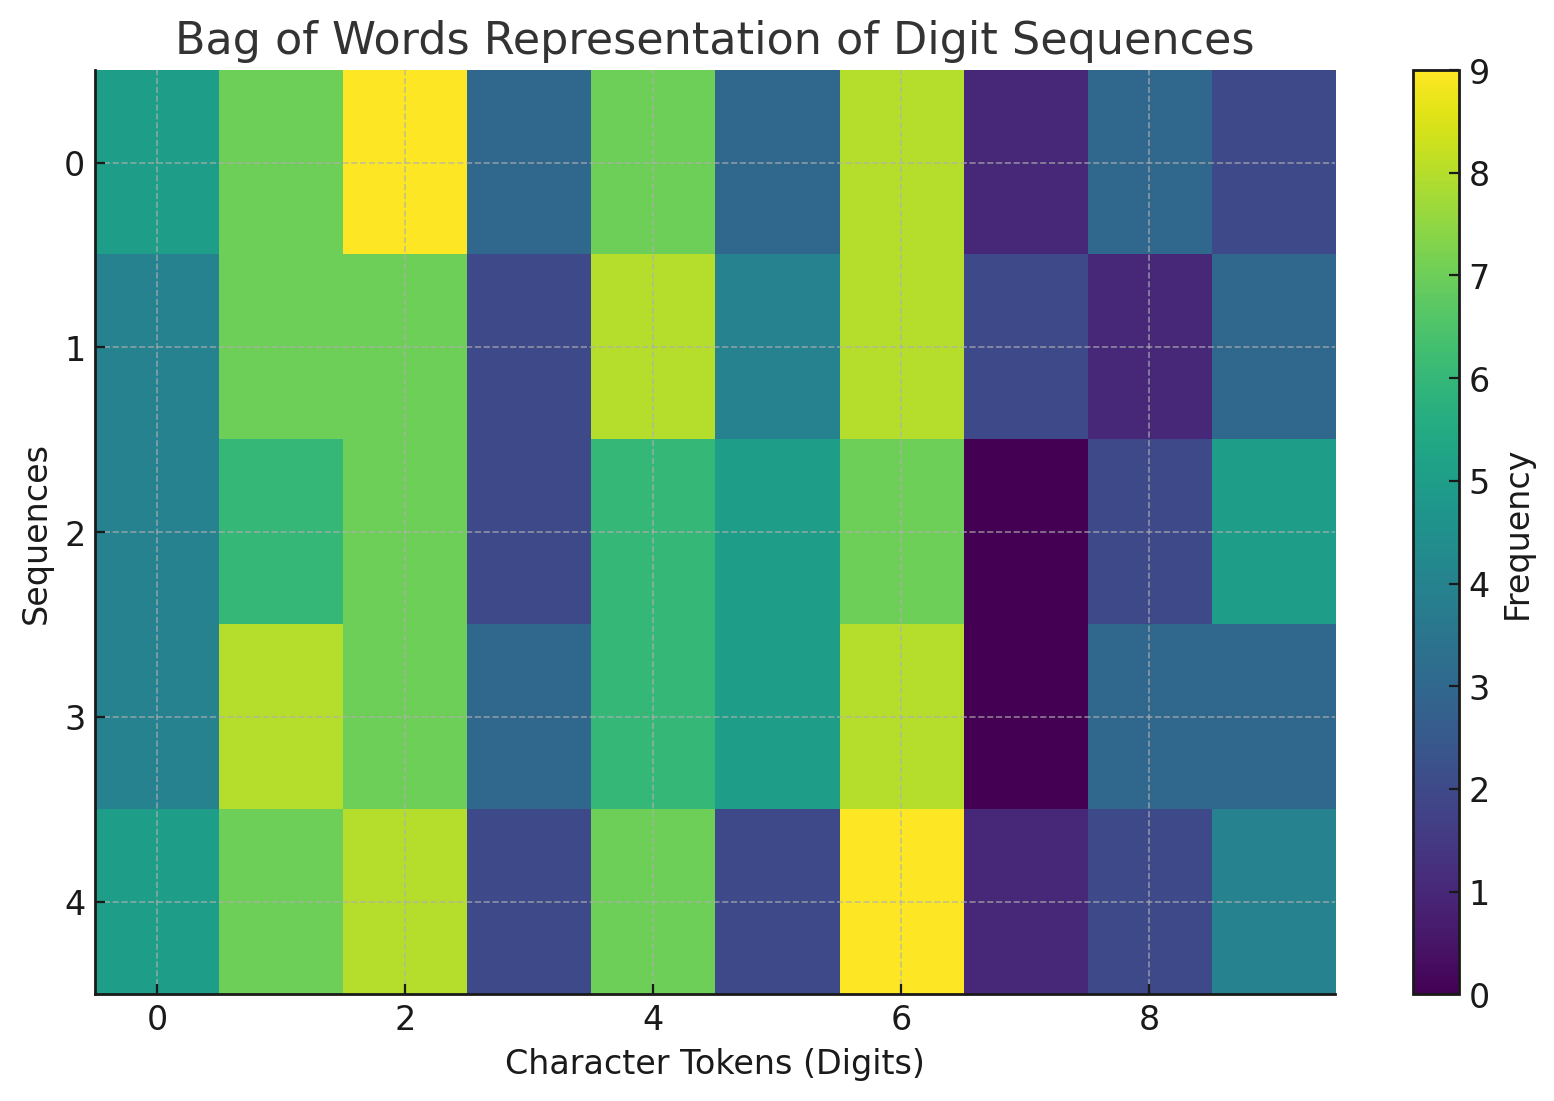

### To reduce dimensions using SVD

In [42]:
from sklearn.decomposition import TruncatedSVD
n_components=200
svd=TruncatedSVD(n_components=200)
X_bow_reduced=svd.fit_transform(X_bow)
X_tfidf_reduced=svd.fit_transform(X_tfidf)


print("Shape after SVD (BoW):", X_bow_reduced.shape)
print("Shape after SVD (TF-IDF):", X_tfidf_reduced.shape)

Shape after SVD (BoW): (7080, 200)
Shape after SVD (TF-IDF): (7080, 200)


In [43]:
X_val_bow_reduced=svd.fit_transform(X_val_bow)
X_val_tfidf_reduced=svd.fit_transform(X_val_tfidf)

print("Shape after SVD (BoW):", X_val_bow_reduced.shape)
print("Shape after SVD (TF-IDF):", X_val_tfidf_reduced.shape)

Shape after SVD (BoW): (489, 200)
Shape after SVD (TF-IDF): (489, 200)


In [34]:
print(X_bow_reduced)

[[-0.00821948  0.0065737   0.00467267 ...  0.00146554  0.01432371
   0.01921523]
 [-0.01454705 -0.01026099  0.01137646 ... -0.01076193  0.01244119
   0.00162133]
 [ 0.00086214  0.01960668  0.01211464 ...  0.00179088 -0.00343064
  -0.00352427]
 ...
 [-0.00067024 -0.0078721  -0.00963902 ... -0.02387554  0.00293555
  -0.00818916]
 [ 0.01530551 -0.00578864  0.0215196  ... -0.01092148  0.0141009
  -0.01376498]
 [ 0.01745995 -0.00618205 -0.00609085 ...  0.01531235 -0.00951473
   0.00461304]]


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


clf=LogisticRegression()
clf.fit(X_bow_reduced, y_train)
y_pred= clf.predict(X_val_bow_reduced)
accuracy=accuracy_score(y_valid, y_pred)
print ("Accuracy: ", accuracy)

Accuracy:  0.4662576687116564


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print(classification_report(y_valid, y_pred))

# Print confusion matrix
print(confusion_matrix(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       252
           1       0.00      0.00      0.00       237

    accuracy                           0.52       489
   macro avg       0.26      0.50      0.34       489
weighted avg       0.27      0.52      0.35       489

[[252   0]
 [237   0]]


C:\Users\ANUSHKA SINGH\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ANUSHKA SINGH\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ANUSHKA SINGH\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f